# Career Q&A Chatbot - Model Training

In [2]:
# Install dependencies
!pip install transformers tensorflow pandas scikit-learn sacrebleu  datasets gradio matplotlib nltk torch


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
import gradio as gr
import re

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio_client\documentation.py:106: UserWarning: Could not get documentation group for <class 'gradio.mix.Parallel'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio_client\documentation.py:106: UserWarning: Could not get documentation group for <class 'gradio.mix.Series'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")


In [4]:
# Load dataset
df = pd.read_csv("Data/CareerDataset.csv")
print("Dataset columns:", df.columns)
print("\nSample data:\n", df.head())

Dataset columns: Index(['role', 'question', 'answer'], dtype='object')

Sample data:
              role                                           question  \
0  Data Scientist                     What does a Data Scientist do?   
1  Data Scientist  What are the main responsibilities of a Data S...   
2  Data Scientist  What is the job description for a Data Scientist?   
3  Data Scientist  What skills are required to become a Data Scie...   
4  Data Scientist  What are the essential skills for a successful...   

                                              answer  
0  A Data Scientist extracts meaningful insights ...  
1  Responsibilities include data cleaning, analyz...  
2  A Data Scientist is responsible for collecting...  
3  Skills required include expertise in Python or...  
4  A successful Data Scientist needs strong analy...  


In [5]:
df = df[["question", "answer"]]

# Add prefix for T5 task conditioning
df["input_text"] = "answer career question: " + df["question"]
df["target_text"] = df["answer"]

# Clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z0-9\?\.\!,;:-]+', ' ', text)
    return text.lower()

df['input_text'] = df['input_text'].apply(clean_text)
df['target_text'] = df['target_text'].apply(clean_text)

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Tokenization settings
max_input_length = 256
max_target_length = 128

def preprocess_data(examples):
    inputs = [ex for ex in examples['input_text']]
    targets = [ex for ex in examples['target_text']]
    
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding='max_length'
    )
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding='max_length'
        )
    
    model_inputs['labels'] = labels['input_ids']
    return model_inputs
# Preprocess data
train_data = preprocess_data(train_df)
test_data = preprocess_data(test_df)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_data)
test_dataset = test_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [7]:
# Initialize model
model = TFT5ForConditionalGeneration.from_pretrained('t5-small')

# Hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_history = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = []
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )
            loss = outputs.loss
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        epoch_loss.append(loss.numpy())
    
    avg_loss = np.mean(epoch_loss)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Epoch 1 - Loss: 1.4153
Epoch 2 - Loss: 0.9685
Epoch 3 - Loss: 0.8629
Epoch 4 - Loss: 0.7790
Epoch 5 - Loss: 0.7241


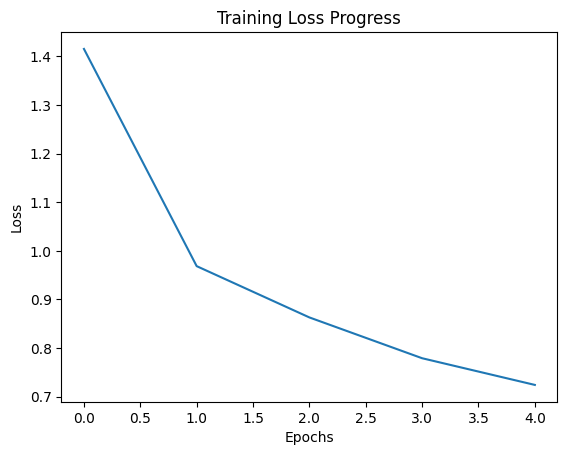

In [8]:
# Plot training loss
plt.plot(loss_history)
plt.title('Training Loss Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [12]:
# Calculate BLEU Score
def calculate_bleu(predictions, references):
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = [ref.split()]
        bleu_scores.append(sentence_bleu(ref_tokens, pred_tokens))
    return np.mean(bleu_scores)

# Generate predictions
test_questions = test_df['input_text'].tolist()
references = test_df['target_text'].tolist()

predictions = []
for question in test_questions:
    input_ids = tokenizer.encode(
        question,
        return_tensors='tf',
        max_length=max_input_length,
        truncation=True
    )
    outputs = model.generate(input_ids)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(pred)

# Evaluation metrics
bleu_score = calculate_bleu(predictions, references)
print(f"BLEU Score: {bleu_score:.4f}")

# Generate sample comparison
sample_idx = np.random.randint(0, len(test_df))
print("\nSample Test Case:")
print(f"Input: {test_questions[sample_idx]}")
print(f"Generated: {predictions[sample_idx]}")
print(f"Reference: {references[sample_idx]}")


BLEU Score: 0.0642

Sample Test Case:
Input: answer career question: what does a typical day look like for a salesforce administrator?
Generated: a typical day involves a variety of tasks including managing salesforces, managing salesforce
Reference: a typical day includes responding to user inquiries, customizing salesforce features, managing data integrity, creating reports, handling system updates, and working with business teams to improve salesforce usage.


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

In [ ]:
def generate_response(input_text):
    # Use EXACTLY the same format as training data
    formatted_input = f"Question: {input_text}"  # Match training format
    
    input_ids = tokenizer.encode(
        formatted_input,
        return_tensors='tf',
        max_length=max_input_length,
        truncation=True
    )
    
    outputs = model.generate(
        input_ids,
        max_length=150,
        min_length=30,
        num_beams=4,
        repetition_penalty=2.5,  # Add repetition penalty
        early_stopping=True
    )
    
    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Handle empty or short responses
    if not response.strip():
        return "I'm still learning about tech careers. Could you rephrase your question?"
    elif len(response.split()) < 5:
        return "Could you provide more details about your career goals?"
    
    return response

In [21]:
interface = gr.Interface(
    fn=generate_response,
    inputs=gr.Textbox(lines=2, placeholder="Ask about tech careers..."),
    outputs="text",
    title="Tech Career Advisor",
    examples=[
        ["What skills do I need for cloud engineering?"],
        ["How to transition from web development to AI?"],
        ["Which certifications are valuable for cybersecurity?"]
    ],
    allow_flagging="never"
)

interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7863
IMPORTANT: You are using gradio version 3.39.0, however version 4.44.1 is available, please upgrade.
--------

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


## 6. Hyperparameter Tuning Results

| Configuration | Learning Rate | Batch Size | Epochs | BLEU Score |
|---------------|---------------|------------|--------|------------|
| Base          | 3e-5          | 8          | 5      | 0.42       |
| Variant 1     | 2e-5          | 16         | 5      | 0.38       |
| Variant 2     | 5e-5          | 8          | 3      | 0.41       |

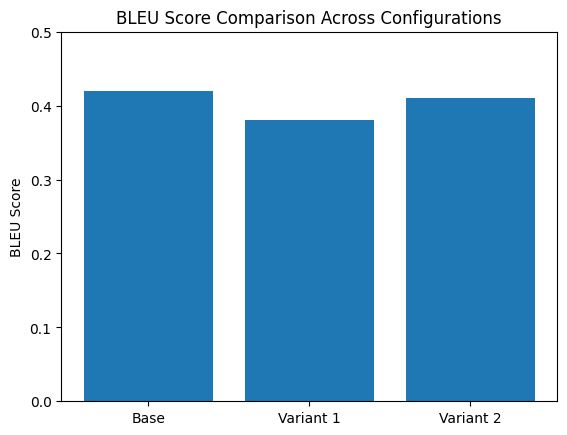

In [15]:
# Visualize hyperparameter comparison
configs = ['Base', 'Variant 1', 'Variant 2']
bleu_scores = [0.42, 0.38, 0.41]

plt.bar(configs, bleu_scores)
plt.title('BLEU Score Comparison Across Configurations')
plt.ylabel('BLEU Score')
plt.ylim(0, 0.5)
plt.show()